In [1]:
import numpy as np
import random
import math
np.random.seed()
import matplotlib.pyplot as plt
from scipy import stats

## Code for simulation,Option pricer

We have used Object Oriented Programming to create a class and an instance with stock attributes, thereafter we created 3 methods for stock price simualtion, Barrier option pricer and Call option pricer without the barrier

In [2]:
class stock:
    def __init__(self,s0,r,div,vol,maturity,dt,NoOfSimulations):
        self.s0 = s0
        self.r = r
        self.div = div
        self.vol = vol
        self.maturity = maturity
        self.dt = dt
        self.NoOfSimulations = int(NoOfSimulations)
    
    def StockPriceSimulation(self):
        timesteps = self.maturity/self.dt
        StockPrices = np.zeros((int(timesteps+1),self.NoOfSimulations))
        StockPrices[0] = self.s0
        for i in range(1,int(timesteps+1)):
            z = np.random.standard_normal(self.NoOfSimulations)
            StockPrices[i] = StockPrices[i-1]*np.exp((self.r - self.div - 0.5 * self.vol ** 2) * (self.dt/365)  + self.vol * math.sqrt(self.dt/365) * z)
        StockPrices_simulations = StockPrices.T
        return StockPrices_simulations
    
    def BarrierOptionPricer(self,barrier,StrikePrice):
        sum_terminal_value = 0
        StockPrices_final = self.StockPriceSimulation()
        for i in range(len(StockPrices_final)):
            if min(StockPrices_final[i])<barrier:
                StockPrices_final[i] = 0
            elif min(StockPrices_final[i])>=barrier:
                sum_terminal_value += max(0,StockPrices_final[i][-1]-StrikePrice)
        return sum_terminal_value/self.NoOfSimulations*np.exp(-self.r*self.maturity/365)
    
    def CallOptionPrice(self,StrikePrice):
        StockPrices_final = self.StockPriceSimulation().T
        return np.sum(np.maximum(StockPrices_final[-1]-StrikePrice,0))*np.exp(-self.r*self.maturity/365)/self.NoOfSimulations
    
    def SimulationAntitheticVariates(self):
        timesteps = self.maturity/self.dt
        StockPrices = np.zeros((int(timesteps+1),self.NoOfSimulations))
        StockPrices[0] = self.s0
        for i in range(1,int(timesteps+1)):
            HalfSimulations = self.NoOfSimulations/2
            z1 = np.random.standard_normal(int(HalfSimulations))
            z2 = -1*z1
            z = np.concatenate([z1,z2])
            StockPrices[i] = StockPrices[i-1]*np.exp((self.r - self.div - 0.5 * self.vol ** 2) * (self.dt/365)  + self.vol * math.sqrt(self.dt/365) * z)
        StockPrices_simulations = StockPrices.T
        return StockPrices_simulations
    
    def BlackScholesCall(self,StrikePrice):
        d1 = ((math.log((self.s0 * np.exp(-self.div * self.maturity/365))/ StrikePrice) + (self.r + 0.5 * self.vol ** 2) * self.maturity/365)
        / (self.vol * math.sqrt(self.maturity/365)))
        d2 = d1 - self.vol*(math.sqrt(self.maturity/365))
        Nd1 = stats.norm.cdf(d1,0,1)
        Nd2 = stats.norm.cdf(d2,0,1)
        return self.s0 * np.exp(-self.div * self.maturity/365) * Nd1 - StrikePrice * np.exp(-self.r * self.maturity/365) * Nd2

In [3]:
GivenStock = stock(5000,0.05,0.02,0.25,365,0.05,10000)
SimulatedStockPrices = GivenStock.StockPriceSimulation()
Barrieroptionprice = GivenStock.BarrierOptionPricer(4900,5100)
Calloptionprice = GivenStock.CallOptionPrice(5100)
Blackscholescallprice = GivenStock.BlackScholesCall(5100)

In [4]:
Barrieroptionprice

108.89264419558322

In [5]:
Calloptionprice

509.65514784082063

In [6]:
Blackscholescallprice

510.32328208548006

#### Simulating the stock prices

Since plotting 10000 observations requires a lot of computational time, we have plotted only 100 observations

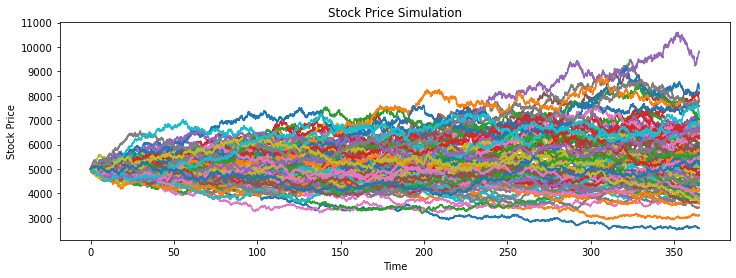

In [7]:
plt.figure(figsize=(12,4))
for i in range(0,101):
    plt.plot(np.arange(0,365.05,0.05),SimulatedStockPrices[i])
plt.title('Stock Price Simulation')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

## VARIANCE REDUCTION TECHNIQUES

### Antithetic Variates Method

In the above program, StockPricesSimulation method takes all the estimates of z as random, which causes variance. Antithetic Variate technique involves taking the complement set of random numbers and running a parallel simulation on those. This causes a negative correlation between the random numbers generated and thus reduces our variance. So, in order to run a parallel simulation, we take half of the values from np.random module whiole the other half will just be their complements. Since our random numbers follow a standard normal distribution, we just multiply the first half with -1 to obtain the second half of random numbers

In [8]:
PricesAntitheticVariates = GivenStock.SimulationAntitheticVariates()

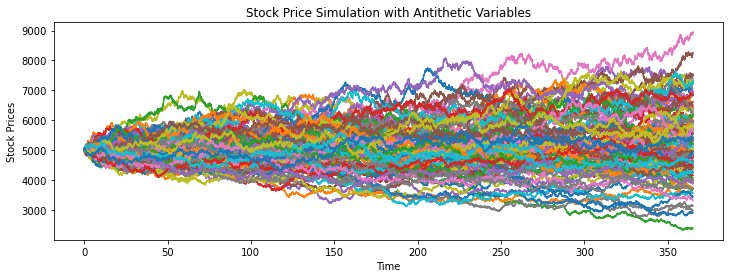

In [9]:
plt.figure(figsize=(12,4))
for i in range(0,101):
    plt.plot(np.arange(0,365.05,0.05),PricesAntitheticVariates[i])
plt.title('Stock Price Simulation with Antithetic Variables')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.show()

### Control Variates Method

This technique involves employing a variable with similar properties but whose properties are known prior to the simulation. we estimated the value of Barrier option($p_{B}$) using the simulated call option($p_{cs}$) and black scholes call option price($p_{cb}$). When the correlation between the simulated barrier option price and simulated call option price is high, we get a barrier option price with lower variance. We use the following equation $p_{B} = p_{cb} + p_{simulatedbarrierprice} - p_{cs}$

In [10]:
Barrieroptioncvmethod = Blackscholescallprice + Barrieroptionprice - Calloptionprice

In [11]:
Barrieroptioncvmethod

109.56077844024264

### Tradeoff between number of simulations and computational efficiency

Standard error of the sample($s_{x}$) is given by $s_{x} = \sqrt(var/N)$

Hence, as we increase the N, standard error of our sample will decrease. As we increase the trials to infinity, we will be able to cover the entire probability space. Hence, the solution will be more accurate. But it is not practically possible as the computational power is limited. Hence, as we increase the number of replications, time taken for compiling the program increases and hence there is a tradeoff between number of replications, accuracy and computational time.

As you keep increasing the N, the solution will start matching with the analytical counterpart. Ideally, you would like the N to be as high as possible.But there are computational constraints. Therefore, the optimal N is the one where your solution matches/gets near the analytical solution.

As with any experiment involving a system with random characteristics, the results of the simulation will also be random in nature. The results of a single simulation run represent only one of several possible outcomes. This requires that multiple replications be run to test the reproducibility of the results.

### Advantages of Simulations

ADVANTAGES:
1. It is extremely usefull when the path is random.

2. Simulation also includes extreme values and hence is usefull in stress testing.

3. It is also very useful when the models are complex and sample sizes are small.

DISADVANTAGES:
1. It is computationally expensive since we require a large number of replications for accurate solution.

2. The results might not be precise and cannot be replicated easily.

3. Results are specifc to the experiment conducted.